In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer

from sklearn.datasets import load_breast_cancer

# Одномерные нелинейные преобразования (используем статистический анализ признаков)

В чем же важность нормального распределения для **регрессионного анализа**?

1. В случае нарушения "нормальности", особенно для распределений с "тяжелыми хвостами" возрастает вероятность появления статистически аномальных значений (выбросов), к которым МНК является очень чувствительным и один такой выброс может кардинально изменить значения параметров модели, полностью исказив картину.

2. В случае нормального распределения имеется прекрасно разработанный математический аппарат проверки гипотез. Непараметрический инструментарий не так обширен (например, критерии отсева выбросов привязаны к конкретному распределению.

## 1. "Примитивная" нормализация 

In [2]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)



In [3]:
print("Частоты значений:\n{}".format(np.bincount(X[:, 0])))

Частоты значений:
[28 38 68 48 61 59 45 56 37 40 35 34 36 26 23 26 27 21 23 23 18 21 10  9
 17  9  7 14 12  7  3  8  4  5  5  3  4  2  4  1  1  3  2  5  3  8  2  5
  2  1  2  3  3  2  2  3  3  0  1  2  1  0  0  3  1  0  0  0  1  3  0  1
  0  2  0  1  1  0  0  0  0  1  0  0  2  2  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  0  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


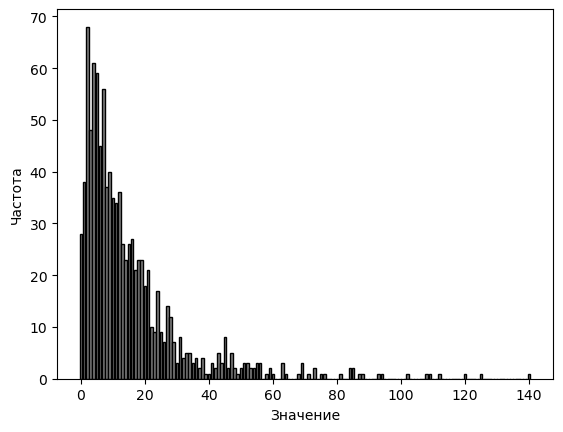

In [4]:
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='gray', edgecolor='black')
plt.ylabel("Частота")
plt.xlabel("Значение");

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print("Правильность на тестовом наборе: {:.3f}".format(score))

Правильность на тестовом наборе: 0.622


In [6]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

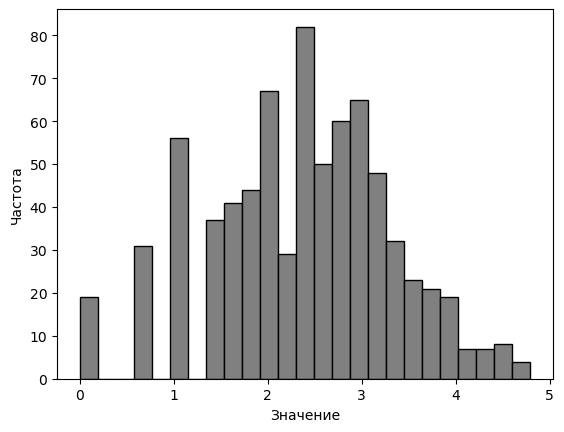

In [7]:
plt.hist(X_train_log[:, 0], bins=25, color='gray', edgecolor='black')
plt.ylabel("Частота")
plt.xlabel("Значение");

In [8]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print("Правильность на тестовом наборе: {:.3f}".format(score))

Правильность на тестовом наборе: 0.875


## 2. Преобразование Бокса-Кокса

Считается, что среди множества  методов преобразований по "нормализации" данных, одним из лучших (при неизвестном типе распределения) считается преобразование Бокса-Кокса.

Преобразование Бокса-Кокса имеет вид:
$$
\tilde{x_i} = 
\begin{cases}
    \dfrac {{x_i}^{\lambda}-1} {\lambda} & \text{if} \quad \lambda \neq 0 \\
    \log(x_i)  & \text{if}  \quad {\lambda} = 0
\end{cases}
$$

Оптимальное значение параметра $\lambda$ может быть найдено методом наибольшего правдоподобия. Подробнее про преобразование Бокса-Кокса - см.  http://www.machinelearning.ru/wiki/index.php?title=Метод_Бокса-Кокса.

**Важное замечание:** Преобразование Бокса-Кокса работает только для положительно определенных данных (MinMaxScaler в помощь...)  

In [9]:
pt = PowerTransformer(method='box-cox')
X_train_pt = pt.fit_transform(X_train + 1)
X_test_pt  = pt.transform(X_test + 1)

score = Ridge().fit(X_train_pt, y_train).score(X_test_pt, y_test)
print("Правильность на тестовом наборе: {:.3f}".format(score))

Правильность на тестовом наборе: 0.883


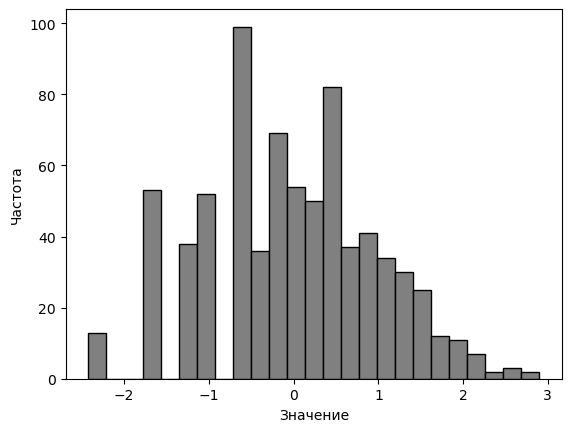

In [10]:
plt.hist(X_train_pt[:, 1], bins=25, color='gray', edgecolor='black')
plt.ylabel("Частота")
plt.xlabel("Значение");

## 3. Преобразование Йео-Джонсона

Преобразование Йео-Джонсона определяется следующим образом:

$$ 
\tilde{x_i} = 
\begin{cases} 
\dfrac{(x_i + 1) ^ \lambda -1}{\lambda} & \text{if} \quad  \lambda \neq 0,\; x_i \geq 0 \\
\log (x_i + 1) & \text{if} \quad \lambda = 0,\; x_i \geq 0 \\
- \dfrac{(-x_i + 1) ^ {(2- \lambda)} - 1 }{2- \lambda} & {\text{if}} \quad \lambda \neq 2,\; x_i<0 \\
\log (-x_i + 1) & \text {if} \quad \lambda = 2,\; x_i <0 
\end{cases}
$$

Оптимальное значение параметра $\lambda$ также может быть найдено методом наибольшего правдоподобия. Позволяет производить преобразование аналогичное преобразованию Бокса-Кокса для любых численных данных.

In [11]:
pt = PowerTransformer(standardize = False) # обратите внимание, что меняет опция  standardize
X_train_pt = pt.fit_transform(X_train)
X_test_pt  = pt.transform(X_test)

score = Ridge().fit(X_train_pt, y_train).score(X_test_pt, y_test)
print("Правильность на тестовом наборе: {:.3f}".format(score))

Правильность на тестовом наборе: 0.883


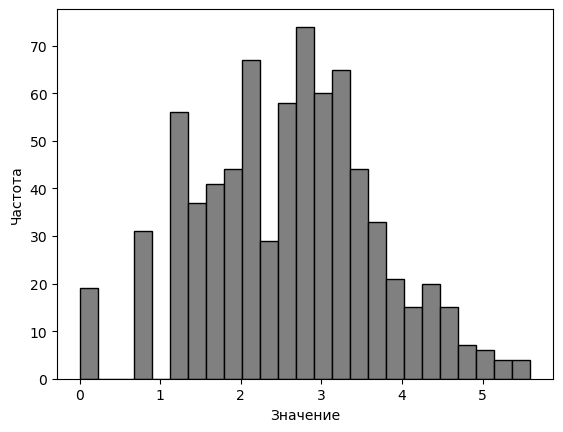

In [12]:
plt.hist(X_train_pt[:, 0], bins=25, color='gray', edgecolor='black')
plt.ylabel("Частота")
plt.xlabel("Значение");

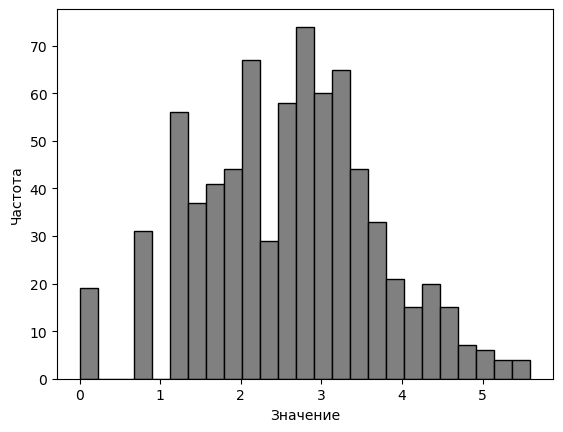

In [13]:
plt.hist(X_train_pt[:,0], bins=25, color='gray', edgecolor='black')
plt.ylabel("Частота")
plt.xlabel("Значение");

# Удаление признаков с низкой дисперсией

Признак с малым разбросом данных, сложен в интерпритации модели машинного мобучения (пожалуй за исключением деревьев, но и там могут возникать проблемы с подбором порога)

<code>VarianceThreshold</code> - это самый простой базовый подход отбору пизнаков. Он удаляет все признаки, дисперсия которых не достигает некоторого порогового значения. По умолчанию он удаляет все признаки с нулевой дисперсией, то есть признаки, которые имеют одинаковое значение во всех выборках.

В качестве примера предположим, что у нас есть набор данных с признакими состоящих из 0 и 1 , и мы хотим удалить все функции, которые равны единице или нулю в более чем 80% строк.

In [14]:
from sklearn.feature_selection import VarianceThreshold

X = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]])
print(X)
transform_threshold = VarianceThreshold(threshold=(.8 * (1 - .8)))
transform_threshold.fit_transform(X)


[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]
 [0 1 1]]


array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

array([False,  True,  True])

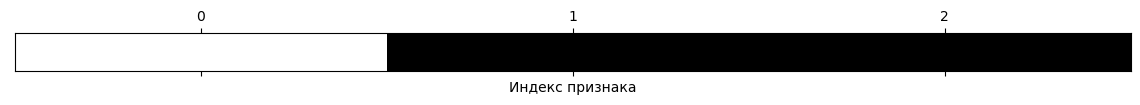

In [15]:
mask = transform_threshold.get_support()
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.1);
plt.yticks([])
plt.xlabel("Индекс признака")
transform_threshold.get_support()

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False, False, False])

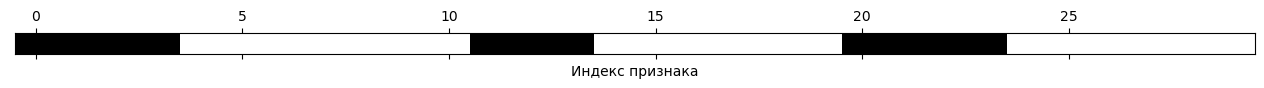

In [16]:
cancer = load_breast_cancer()
rng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0, test_size=.3)

#ths = 0
ths = (.9 * (1 - .9))
cancer_var = VarianceThreshold(threshold = ths)
cancer_var.fit_transform(X_train)
mask = cancer_var.get_support()


plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.xlabel("Индекс признака")
cancer_var.get_support()

In [17]:
cancer.data

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

# Cтатический отбор признаков

Общая стратегия. Добавим шум к признакам. Если исходные признаки статистически слабее шума, алгоритм их отбросит. Внимание работа ведется только на анализе статистических данных!

Рассмотрим признак на основе ссамого высокого процента баллов

In [18]:
from sklearn.feature_selection import SelectPercentile

cancer = load_breast_cancer()

# задаем определенное стартовое значение для воспроизводимости результата
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# добавляем к данным шумовые признаки
# первые 30 признаков являются исходными, остальные 50 являются шумовыми
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)
# используем f_classif (по умолчанию)
# и SelectPercentile, чтобы выбрать 50% признаков
select_pct = SelectPercentile(percentile=50)
select_pct.fit(X_train, y_train)
# преобразовываем обучающий набор
X_train_selected = select_pct.transform(X_train)

print("форма массива X_train: {}".format(X_train.shape))
print("форма массива X_train_selected: {}".format(X_train_selected.shape))

форма массива X_train: (284, 80)
форма массива X_train_selected: (284, 40)


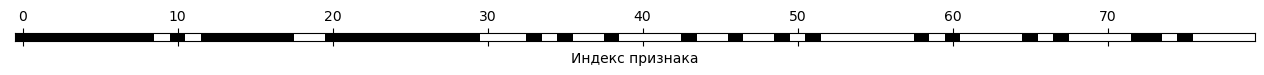

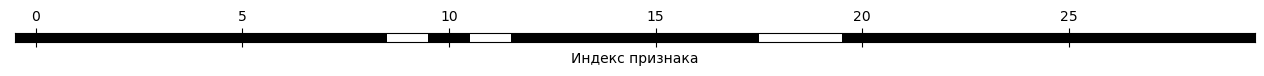

In [19]:
mask = select_pct.get_support()
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.xlabel("Индекс признака");

mask = select_pct.get_support()[:30]
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.2)
plt.yticks([])
plt.xlabel("Индекс признака");


Варианты отбора признаков:
1. Отбор k наиболее сильных признаков <code>SelectKBest</code>
2. Отбор признаков усиливающих отбор:
    - контролирует отбор FPR (ложно позитивных признаков) <code>SelectFpr</code>¶
    - контролирует отбор признаков с высокой вероятности ложного обнаружения <code>SelectFdr</code>¶
    - контролирует отбор признаков с высокой "familywise error rat" <code>SelectFwe</code>¶
    
3. Позволяет использовать отбор любых ранее указаных признаков, как опций <code>mode</code> с  помощью <code>GenericUnivariateSelect</code>

# Построение простой важности признаков

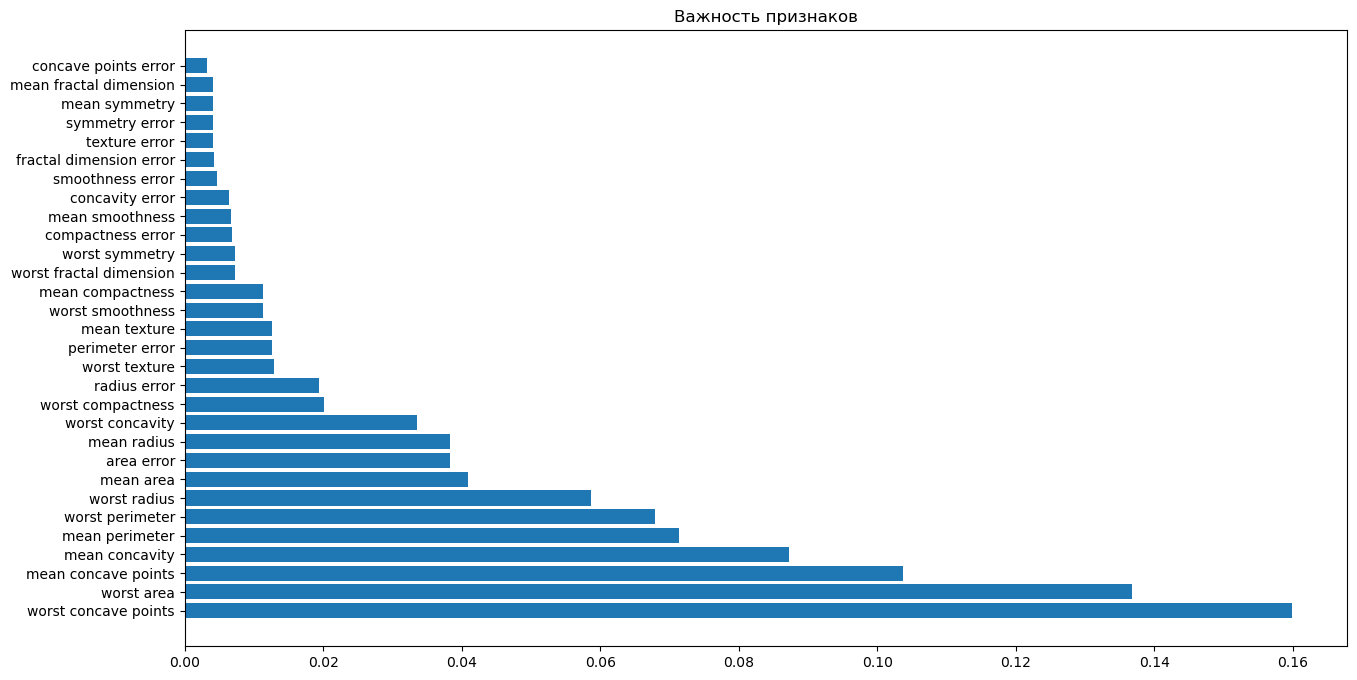

In [20]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0, test_size=.3)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train,y_train)

plt.figure(figsize=(15,8))
feature_names = np.array(cancer.feature_names)
#importance = rfc.feature_importances_

importance = np.sort(rfc.feature_importances_)
importance_name = np.argsort(rfc.feature_importances_)

plt.barh(width=importance, y = feature_names[importance_name] )
ax = plt.gca()
ax.invert_yaxis()
plt.title("Важность признаков")
plt.show()

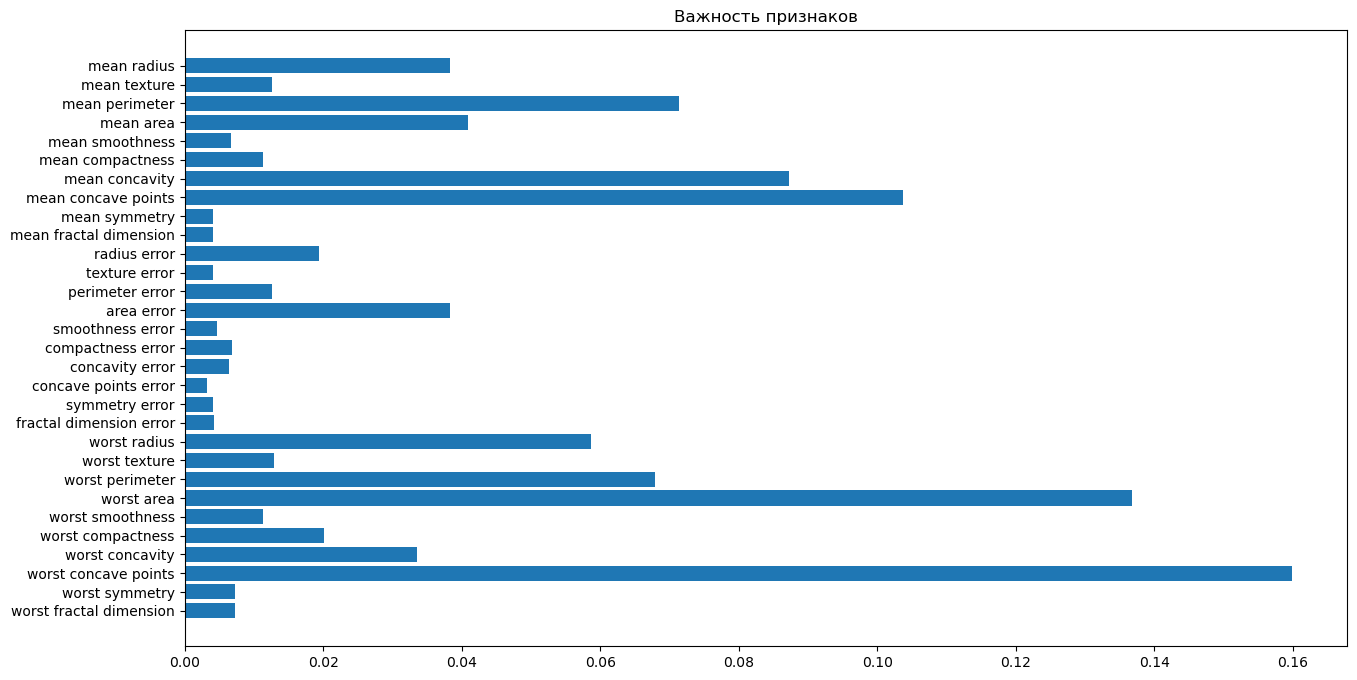

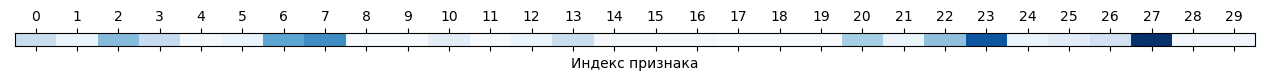

In [21]:
importance = rfc.feature_importances_

plt.figure(figsize=(15,8))
plt.barh(width=importance, y=feature_names)
plt.gca().invert_yaxis()
plt.title("Важность признаков")
plt.show()

mask = importance
plt.matshow( mask.reshape(1,-1), cmap = 'Blues', aspect=0.3)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");


# Рекурсивный отбор признаков

Стоим модель, находим значимость признаков, затем убираем самый слабый признак и повторяем ...

Приведем пример с шумом, для обора значимых признаков.

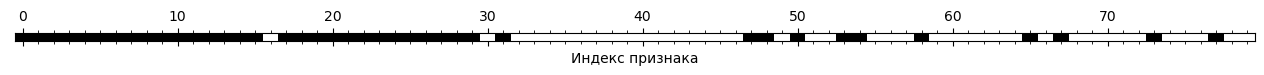

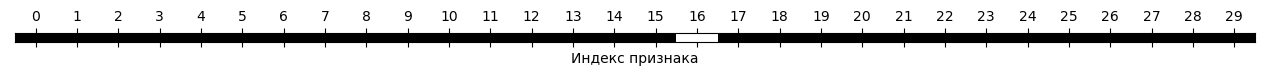

In [22]:
from sklearn.feature_selection  import RFE
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)

rfe_select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

rfe_select.fit(X_train, y_train)


# визуализируем отобранные признаки:
mask = rfe_select.get_support()
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

mask = rfe_select.get_support()[:30]
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.2)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

Вариант рекурсивного отбора признаков с кросвалидацией <code>RFECV</code>

Пример применения с использованием кода из справки. В данном случае мы пытаемся выделить линейнозависимые признаки.

Оптимально : 5


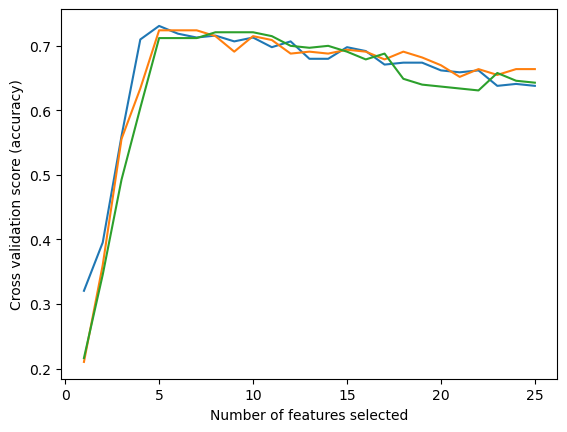

In [23]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 5 informative features
X, y = make_classification(
    n_samples=1000,
    n_features=25,
    n_informative=5, # 5 информативных признаков, остальные линейная комбинация
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    random_state=0,
)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

print("Оптимально : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
filtered = pd.DataFrame(rfecv.cv_results_).filter(regex='split') #[s for s in rfecv.cv_results_.keys() if 'split' in s]
plt.plot(
    range(min_features_to_select, len(filtered) + min_features_to_select),
    filtered
)
plt.show()

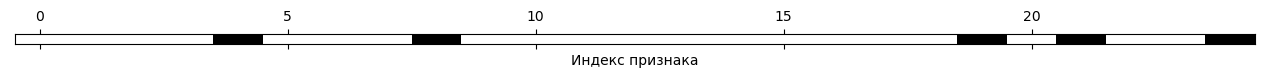

In [24]:
# Выделим признаки
mask = rfecv.get_support()
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.2)
plt.yticks([])
plt.xlabel("Индекс признака");

## Отбор признаков на основе модели

форма обуч набора X: (284, 30)
форма обуч набора X median: (284, 15)


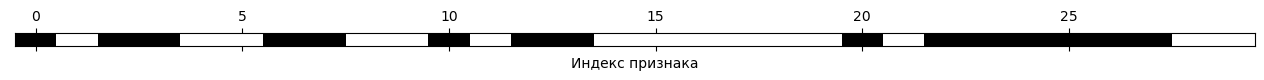

----------------------------------------------------
форма обуч набора X: (284, 30)
форма обуч набора X median: (284, 21)


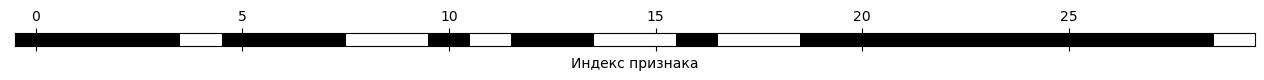

----------------------------------------------------
форма обуч набора X: (284, 30)
форма обуч набора X median: (284, 20)


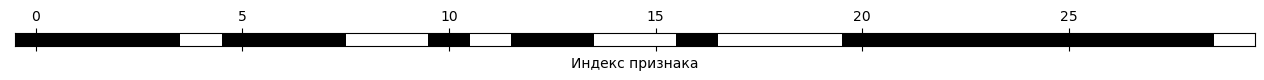

In [25]:
from sklearn.feature_selection import SelectFromModel
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0, test_size=.5)


select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

select.fit(X_train, y_train)
X_train_med = select.transform(X_train)
print("форма обуч набора X: {}".format(X_train.shape))
print("форма обуч набора X median: {}".format(X_train_med.shape))
mask = select.get_support()
# визуализируем булевы значения -- черный – True, белый – False
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.3)
plt.yticks([])
plt.xlabel("Индекс признака");
plt.show();

print("----------------------------------------------------")

select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="0.2*mean")         # внимание на синтаксис
select.fit(X_train, y_train)
X_train_mean = select.transform(X_train)
print("форма обуч набора X: {}".format(X_train.shape))
print("форма обуч набора X median: {}".format(X_train_mean.shape))
mask = select.get_support()
# визуализируем булевы значения -- черный – True, белый – False
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.3)
plt.yticks([])
plt.xlabel("Индекс признака");
plt.show();

print("----------------------------------------------------")

select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold = -np.inf,     # внимание на синтаксис
    max_features = 
    20 )         # внимание на синтаксис
select.fit(X_train, y_train)
X_train_mean = select.transform(X_train)
print("форма обуч набора X: {}".format(X_train.shape))
print("форма обуч набора X median: {}".format(X_train_mean.shape))
mask = select.get_support()
# визуализируем булевы значения -- черный – True, белый – False
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.3)
plt.yticks([])
plt.xlabel("Индекс признака");
plt.show();

## Последовательный отбор признаков SequentialFeatureSelector (SFS)

SFS может быть как вперед, так и назад. Отличие SFS от RFE и SelectFromModel заключается в том, что базовая модель не должна предоставлять атрибуты важности признаков (<code>coef_</code> или <code>feature_importances_</code>), поэтому отбор признаковбудет медленне. Например, при переходе от $m$ к $m-1$ признаку с использованием $k$-кратной перекресной проверке потребует проверку $m*k$ моделей, а при использовании RFE только одной модели.

Как правило, прямой и обратный отбор не дают одинаковых результатов. Кроме того, одна может быть намного быстрее, чем другая, в зависимости от запрошенного количества выбранных функций: если у нас есть 10 функций и мы запрашиваем 7 выбранных функций, для прямого выбора потребуется выполнить 7 итераций, а для обратного выбора потребуется выполнить только 3.

Внимание! Считаться будет оооочень долго.

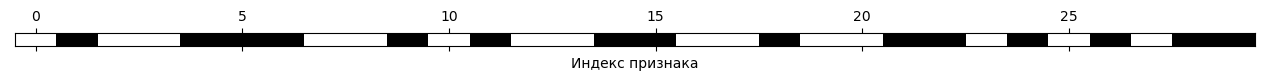

In [26]:
from sklearn.feature_selection import SequentialFeatureSelector
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0, test_size=.5)

select_f = SequentialFeatureSelector(
             RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=15, 
             direction="forward")

select_f.fit(X_train, y_train)
# визуализируем отобранные признаки:
mask = select_f.get_support()
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.3)
plt.yticks([])
plt.xlabel("Индекс признака");
plt.show();

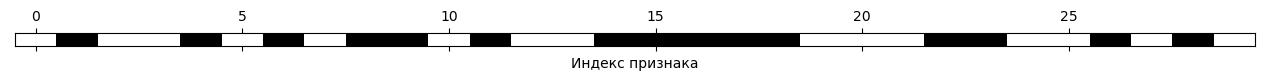

In [27]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0, test_size=.5)

select_b = SequentialFeatureSelector(
             RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=15, 
             direction="backward")

select_b.fit(X_train, y_train)
# визуализируем отобранные признаки:
mask = select_b.get_support()
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.3)
plt.yticks([])
plt.xlabel("Индекс признака");
plt.show();